In [1]:
# importing the packages
import fitsio
from astropy.io import fits
import matplotlib.pyplot as plt
import astropy.table as t
# importing all modules
import os
import fitsio
import matplotlib.pyplot as plt
import glob
from astropy.io import fits
import numpy as np
import astropy.table as t
import subprocess
import json 
import scipy.optimize as so
from scipy.integrate import odeint
import numpy.ma as ma
from scipy.stats import linregress
import pandas as pd
from scipy.stats import binned_statistic as bn
import pickle
import h5py
import redrock.templates
import multiprocessing
import random
from desitarget.targetmask import desi_mask, bgs_mask
chi2cut=25

In [6]:
#this only loads the rr templates
templates = dict()

for filename in redrock.templates.find_templates():
    l = redrock.templates.Template(filename) #check if you can add a "verbose=False"
    templates[(l.template_type, l.sub_type)] = l

DEBUG: Read templates from /global/common/software/desi/perlmutter/desiconda/20230111-2.1.0/code/redrock-templates/main
DEBUG: Using default redshift range -0.0050-1.6997 for rrtemplate-galaxy.fits
DEBUG: Using redshift range 1.4000-6.9930 for rrtemplate-qso-HIZ.fits
DEBUG: Using redshift range 0.0500-1.5983 for rrtemplate-qso-LOZ.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-A.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-B.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-CV.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-F.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-G.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-K.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-M.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-WD.fits


In [138]:
# tiles used for analysis
# tiles=['80605','80606','80608','80609','80610','80613',"80653","80654","80655","80656","80657","80658","80659","80660","80661","80662","80663","80664","80665","80666","80669","80670","80673","80674","80675","80676","80677","80678","80679","80680","80681","80682","80683","80684","80685","80686","80687","80688","80689","80690","80691","80692","80693","80694","80695","80696","80697","80698","80699","80700","80701","80702","80703","80705","80706","80707","80708","80709","80710","80711","80712","80715","80718","80719","80720","80721","80722","80724","80726","80728","80729","80730","80731","80732","80733","80734","80735","80736","80737","80738","807chi2cut","80741","80742","80782","80783","80784","80785","80786","80787","80788","80789","80790","80856","80857","80858","80859","80860","80861","80862","80863","80865","80866","80867","80869","80870","80871","80872","80873","80875","80876","80879","80882","80885","80886","80887","80888","80889","80890","80891","80892","80893","80894","80895","80896","80897","80898","80899","80900","80901","80902","80938","80944","80949","80950","80951","80952","80954","80955","80956","80958","80959","80960","80962","80963","80966","80968","80970","80971","80972","80974","80975","81000","81001","81002","81003","81004","81005","81006","81007","81008","81009","81010","81011","81012","81013","81014","81015","81022","81056","81057","81058","81059","81060","81061","81062","81063","81064","81065","81066","81067","81068","81069","81072","81073","81074","81075","81088","81097","81098","81099","81100","81101","81102","81103","81104","81105","81106","81107","81108","81109","81110","81111","81112","81113","81114","81115"]
# tiles=['80605','80606'] # if you want to test a particular file
irontiles=glob.glob('/global/cfs/cdirs/desi/spectro/redux/iron/tiles/pernight/*/*')
night=[int(t.split('/')[-1]) for t in irontiles]
night=[str(t) for t in night]
irontiles=[int(t.split('/')[-2]) for t in irontiles]
irontiles=[str(t) for t in irontiles]
tiles=irontiles[:]
print(len(tiles))

1298


In [139]:
# running slurm scripts
for x,tileid in enumerate(tiles):
        scriptfile=(f"/pscratch/sd/s/shirsh/iron_cat_pernight/{tileid}{night[x]}.slurm")
        with open(scriptfile,"w") as y:
            y.write(
f"""#!/bin/bash
#SBATCH -N 1
#SBATCH -C cpu
#SBATCH -q regular
#SBATCH -J ironcat
#SBATCH --mail-user=Shirsh.Chhabra@lmu.de
#SBATCH --mail-type=ALL
#SBATCH -t 00:30:00
source /global/common/software/desi/desi_environment.sh
#OpenMP settings:
export OMP_NUM_THREADS=32
export OMP_PLACES=threads
export OMP_PROC_BIND=spread
export SPECPROD=daily
python /pscratch/sd/s/shirsh/iron_cat_pernight/irontile{tileid}night{night[x]}.py
""")
        scriptfile=(f"/pscratch/sd/s/shirsh/iron_cat_pernight/irontile{tileid}night{night[x]}.py")
        with open(scriptfile,"w") as y:
            y.write(
f"""
# importing the packages
import fitsio
from astropy.io import fits
import matplotlib.pyplot as plt
import astropy.table as t
# importing all modules
import os
import fitsio
import matplotlib.pyplot as plt
import glob
from astropy.io import fits
import numpy as np
import astropy.table as t
import subprocess
import json 
import scipy.optimize as so
from scipy.integrate import odeint
from scipy.stats import linregress
import pandas as pd
from scipy.stats import binned_statistic as bn
import pickle
import h5py
import redrock.templates
import multiprocessing
import random
from desitarget.targetmask import desi_mask, bgs_mask
chi2cut=25

templates = dict()

for filename in redrock.templates.find_templates():
    l = redrock.templates.Template(filename) #check if you can add a "verbose=False"
    templates[(l.template_type, l.sub_type)] = l
# function definitions to make catalog
def read_tile_catalog(tile_string):
    # Read galaxy catalog of a tile including line fit information of all objects
    # input: string with the ID of the tile, e.g. "80605"
    # returns: structured array with catalog of all objects in that tile
    
    emlist = glob.glob('/global/cfs/cdirs/desi/spectro/redux/iron/tiles/pernight/'+str({tileid})+'/'+'{night[x]}'+'/emline*.fits')
    emlist.sort()
    emtable = t.Table()
    for filename in emlist:
        emread2=fits.open(filename)
        dumtable=t.Table.read(emread2[1])
        dumtable['RRFN']=dumtable.meta['RRFN']
        dumtable['TILEID']=int(tile_string)
        dumtable['FN']=filename
        dumtable['RRN']=filename.replace('emline','rrdetails').replace('fits','h5')
        dumtable['COADDFN']=dumtable.meta['COADDFN']
        rrtable=t.Table.read(dumtable['RRFN'][0],hdu='FIBERMAP')
        dumtable['FIBERSTATUS']=rrtable['COADD_FIBERSTATUS']
        dumtable['BGS_TARGET']=rrtable['BGS_TARGET']
        dumtable['COADD_EXPTIME']=rrtable['COADD_EXPTIME']
        dumtable['DESI_TARGET']=rrtable['DESI_TARGET']
        # dumtable['SV1_DESI_TARGET']=0
        # dumtable['SV2_DESI_TARGET']=0
        # dumtable['SV3_DESI_TARGET']=0
        # dumtable['SV1_BGS_TARGET']=0
        # dumtable['SV2_BGS_TARGET']=0
        # dumtable['SV3_BGS_TARGET']=0
        if 'SV1_DESI_TARGET' in rrtable.keys():
             dumtable['SV1_DESI_TARGET']=rrtable['SV1_DESI_TARGET']
        if 'SV2_DESI_TARGET' in rrtable.keys():
             dumtable['SV2_DESI_TARGET']=rrtable['SV2_DESI_TARGET']
        if 'SV3_DESI_TARGET' in rrtable.keys():
             dumtable['SV3_DESI_TARGET']=rrtable['SV3_DESI_TARGET']
        if 'SV1_BGS_TARGET' in rrtable.keys():
             dumtable['SV1_BGS_TARGET']=rrtable['SV1_BGS_TARGET']
        if 'SV2_BGS_TARGET' in rrtable.keys():
             dumtable['SV2_BGS_TARGET']=rrtable['SV2_BGS_TARGET']
        if 'SV3_BGS_TARGET' in rrtable.keys():
             dumtable['SV3_BGS_TARGET']=rrtable['SV3_BGS_TARGET']
        emtable=t.vstack([dumtable,emtable])
    
    return emtable

def filter_galaxies(catalog):
    # print(catalog.keys())
    # Filter catalog to only include galaxy targets among spectype and targets among different, return the filtered catalog
    return catalog[(catalog['SPECTYPE']=='GALAXY') & (catalog['OBJTYPE']=='TGT') & (catalog["FIBERSTATUS"]==0) & (catalog['ZWARN'] == 0)]


# Making the catalog - filtering targets according to choice (could also be done in the very end)
catalog = read_tile_catalog({tileid})
catalog = filter_galaxies(catalog)
if 'TILEID' not in catalog.colnames:
            catalog['TILEID']=np.array([s.split('cumulative/')[1].split('/')[0] for s in catalog['FN']],dtype=int)
if 'RRN' not in catalog.colnames:
            catalog['RRN']=np.array([f.replace('fits','h5').replace('emline','rrdetails') for f in catalog['FN']])
catalog.sort('COADDFN')

# penalty calculation 3 - per arm, median continuum, +ve penalty 
# finding the data, model, computing penalties for 1 tile
zoiii=[]
penoiii=[]
zchi2oiii=[]
check=[]

   
def parallel_penalties(fn):
    #lets do those once per file to save memory
    outdict={{}}
    g=[]
    mi=[]
    xi=[]
    z=[]
    chi2=[]
    pentmp=[]
    out_old_penalty=[]
    chi2_nopen=[]

    selector=catalog['COADDFN']==fn
    entries=catalog[selector]
    # print(len(entries))
    if len(entries)==0:
        print(f"no entries for file{{fn}}")
        return None,None,None, None, None
    
    fnrr=entries['RRFN'][0]
    fnrr_details=entries['RRN'][0]
        
    rrf=fitsio.FITS(fnrr)
    fobj=fitsio.FITS(fn)
    rr_details = h5py.File(fnrr_details, mode='r')

    fm=fobj['FIBERMAP']
    tids=fm['TARGETID'][:]
    for j,entry in enumerate(entries):
        
        if entry['TARGETID'] in tids:
            index=(fm['TARGETID'][:]==entry['TARGETID']).nonzero()[0]
            g.append(entry['TARGETID'])
            # print(index, entry['TARGETID'])
            outdict[entry['TARGETID']]={{'wave':[],'flux':[],'ivar':[],'mask':[],'redshift':rrf['REDSHIFTS']['Z'][index],'petal':fn.split('/')[-1].split('-')[1],'tile':fn.split('/')[-1].split('-')[2]}}            
            for color in 'BRZ':
                outdict[entry['TARGETID']]['wave'].append(fobj[f'{{color}}_WAVELENGTH'][:])
                outdict[entry['TARGETID']]['flux'].append(fobj[f'{{color}}_FLUX'][index:index+1,:][0])
                outdict[entry['TARGETID']]['ivar'].append(fobj[f'{{color}}_IVAR'][index:index+1,:][0])
                outdict[entry['TARGETID']]['mask'].append(fobj[f'{{color}}_MASK'][index:index+1,:][0])    
                
            zfit = t.Table(np.array(rr_details['zfit'][str(entry['TARGETID'])]['zfit']))
            
            tflux=[]
            twave=[]
            zmod=[]
            penmod=[]  
            chi2sintar=[]
            oldpen=[]
            oldchi2nopen=[]
            close_z=[]
            for p in range(0,len(zfit['z'])):
                fulltype=((zfit['spectype'][p],zfit['subtype'][p]))
                # print(fulltype)
                tflux.append(templates[fulltype].flux.T.dot(zfit['coeff'][p][:templates[fulltype].flux.shape[0]]))
                twave.append(templates[fulltype].wave * (1+zfit['z'][p]))
                zmod.append(zfit['z'][p])
                chi2sintar.append(zfit['chi2'][p])
            
                if zfit['spectype'][p]=='GALAXY':
                    z_from_fit=zfit['z'][p]
                    closest_zind=np.argmin(np.abs(rr_details['zscan']['GALAXY']['redshifts'][:]-z_from_fit))
                    closest_z=rr_details['zscan']['GALAXY']['redshifts'][closest_zind]
                    unpenalized_chi2=rr_details['zscan']['GALAXY']['zchi2'][(rr_details['targetids']==entry['TARGETID']).nonzero()[0][0],closest_zind]
                    old_penalty=rr_details['zscan']['GALAXY']['penalty'][(rr_details['targetids']==entry['TARGETID']).nonzero()[0][0],closest_zind]
                    close_z.append(closest_z)
                    oldpen.append(old_penalty)
                    oldchi2nopen.append(unpenalized_chi2)
                else:
                    penline=np.zeros((3,3))
                    oldpen.append(0)
                    close_z.append(zfit['z'][p])
                    oldchi2nopen.append(0)
                    penmod.append(penline)
                    continue
                
                penline=[]
                for linetype in ['OIII_right','OIII_left','OII']:
                    if linetype=='OIII_right':
                        linemin=5000*(1+zmod[p])
                        linemax=5015*(1+zmod[p])
                        cont1min=4980*(1+zmod[p])
                        cont1max=4990*(1+zmod[p])
                        cont2min=5025*(1+zmod[p])
                        cont2max=5035*(1+zmod[p])
                    elif linetype=='OIII_left':
                        linemin=4952*(1+zmod[p]) #modify range
                        linemax=4967*(1+zmod[p])
                        cont1min=4930*(1+zmod[p])
                        cont1max=4940*(1+zmod[p])
                        cont2min=4975*(1+zmod[p])
                        cont2max=4985*(1+zmod[p])
                    elif linetype=='OII':
                        linemin=3720*(1+zmod[p]) #modify ranges
                        linemax=3735*(1+zmod[p])
                        cont1min=3700*(1+zmod[p])
                        cont1max=3710*(1+zmod[p])
                        cont2min=3745*(1+zmod[p])
                        cont2max=3755*(1+zmod[p])
                    line=linemax-linemin
                    cont1=cont1max-cont1min
                    cont2=cont2max-cont2min    
                    bindatline=[]
                    bindatcont1=[]
                    bindatcont2=[]
                    binsigline=[]
                    binsigcont1=[]
                    binsigcont2=[]
                    wdaty=[]
                    datx=[]
                    sigy=[]  
                    wl=[]
                    daty=[]
                    binwdatline=[]
                    penarm=[]
                    #this loop calculates penalty for different arms per single line
                    for i in range(0,3):
    
                        datydum=outdict[entry['TARGETID']]['flux'][i][outdict[entry['TARGETID']]['mask'][i]==0]
                        minx=np.nanmin(outdict[entry['TARGETID']]['wave'][i])
                        maxx=np.nanmax(outdict[entry['TARGETID']]['wave'][i])
                        datxdum=outdict[entry['TARGETID']]['wave'][i][outdict[entry['TARGETID']]['mask'][i]==0]
                        sigydum=outdict[entry['TARGETID']]['ivar'][i][outdict[entry['TARGETID']]['mask'][i]==0] 
                        # datplot, =plt.plot(datxdum,datydum,zorder=10)
                        # sigplot, =plt.plot(datxdum,sigydum)
                        daty=np.array(datydum)
                        datx=np.array(datxdum)
                        sigy=np.array(sigydum)
                        # if len(datx)==0:
                        #     print(entry['TARGETID'])
                        if linemin>max(outdict[entry['TARGETID']]['wave'][i]) or linemax<min(outdict[entry['TARGETID']]['wave'][i]):
                            penarm.append(0)
                            continue
                        datxlin=datx[(datx>=linemin)*(datx<=linemax)]
                        datxcont1=datx[(datx>=cont1min)*(datx<=cont1max)]
                        datxcont2=datx[(datx>=cont2min)*(datx<=cont2max)]
                        datylin=daty[(datx>=linemin)*(datx<=linemax)]
                        datycont1=daty[(datx>=cont1min)*(datx<=cont1max)]
                        datycont2=daty[(datx>=cont2min)*(datx<=cont2max)]
                        sigylin=sigy[(datx>=linemin)*(datx<=linemax)]
                        sigycont1=sigy[(datx>=cont1min)*(datx<=cont1max)]
                        sigycont2=sigy[(datx>=cont2min)*(datx<=cont2max)]
                        wdaty=daty*sigy
                        wdatylin=wdaty[(datx>=linemin)*(datx<=linemax)]
                        wdatycont1=wdaty[(datx>=linemin)*(datx<=linemax)]
                        wdatycont2=wdaty[(datx>=linemin)*(datx<=linemax)]
                        binmod,l,_=bn(twave[p],tflux[p], bins=np.arange(minx-0.4,maxx+0.4+1e-5,0.8))
                        # if len(binmod)!=len(datx):
                        #  print(min(l+0.4),min(datx),max(l+0.4),max(datx))
                        binmod=binmod[outdict[entry['TARGETID']]['mask'][i]==0]
                        binmodline=binmod[(datx>=linemin)*(datx<=linemax)]
                        binmodcont1=binmod[(datx>=cont1min)*(datx<=cont1max)]
                        binmodcont2=binmod[(datx>=cont2min)*(datx<=cont2max)]
                        # binmodline,q,_=bn(twave[p],tflux[p], bins=np.linspace(np.nanmin(datxlin)-0.4,np.nanmax(datxlin)+0.4,int((np.nanmax(datxlin)+0.4-(np.nanmin(datxlin)-0.4))/0.8)+1))
                        # binlinex,_,_=bn(twave[p],twave[p], bins=np.arange(linemin,linemax,0.8))
                        # if len(datxcont1)!=0:
                        #  binmodcont1,x,_=bn(twave[p],tflux[p], bins=np.linspace(np.nanmin(datxcont1)-0.4,np.nanmax(datxcont1)+0.4,int((np.nanmax(datxcont1)+0.4-(np.nanmin(datxcont1)-0.4))/0.8)+1))
                        # else:
                        #  binmodcont1=np.nan
                        # # bincont1x,x,_=bn(twave[p],twave[p], bins=np.arange(cont1min,cont1max,0.8))
                        # if len(datxcont2)!=0:
                        #  binmodcont2,_,_=bn(twave[p],tflux[p], bins=np.linspace(np.nanmin(datxcont2)-0.4,np.nanmax(datxcont2)+0.4,int((np.nanmax(datxcont2)+0.4-(np.nanmin(datxcont2)-0.4))/0.8)+1))
                        # else: 
                        #  binmodcont2=np.nan
                        # bincont2x,_,_=bn(twave[p],twave[p], bins=np.arange(cont2min,cont2max,0.8))
                        
                        # binmodline=binmodline[(binlinex>=min(datx))*(binlinex<=max(datx))]
                        # binmodcont1=binmodcont1[(bincont1x>=min(datx))*(bincont1x<=max(datx))]
                        # binmodcont2=binmodcont2[(bincont2x>=min(datx))*(bincont2x<=max(datx))]
                        #finding the data continuum median
                        # wdatcont=np.concatenate((binwdatycont1,binwdatycont2))
                        sigcont=np.concatenate((sigycont1,sigycont2))
                        datcont=np.nanmedian(np.concatenate([datycont1,datycont2]))
                        #finding the model continuum average
                        modcont=np.nanmedian(np.concatenate([binmodcont1,binmodcont2]))
                        csd=datylin-datcont
                        csm=binmodline-modcont
                        # av=[]
                        # if len(csm)!=len(csd):
                        #     for u in range(0,len(q)-1):
                        #         av.append((q[u]+q[u+1])/2)
                        #     print(datxlin)
                        binpen=csm[(csm<0)]*(2*csd[(csm<0)]-csm[(csm<0)])*sigylin[(csm<0)]
                        penarm.append(np.nansum(binpen[binpen>0])) # final array of len 3
                        
                    penline.append(penarm) # final array of 3*3
                    
                penmod.append(penline) # final array of 9*3*3
                
            #print(np.array(zmod).shape)
            chi2_nopen.append(oldchi2nopen)
            out_old_penalty.append(oldpen)
            
            pentmp.append(penmod) # final array of numtar*9*3*3
            z.append(zmod)
            chi2.append(chi2sintar)

    return pentmp, z, chi2, chi2_nopen, out_old_penalty
    
with multiprocessing.Pool(16) as pool:
        out=pool.map(parallel_penalties,np.unique(catalog['COADDFN']))
        out=[o for o in out if o[0] is not None]
        
# storing the penalty outputs
pen=[o[0] for o in out]
z=[o[1] for o in out]
chi2=[o[2] for o in out]
chi2_nopen=[o[3] for o in out]
old_penalty=[o[4] for o in out]


# merging the output in the shape of the catalog and penalty per line
# only for per arm penalty algorithm
penmer=np.concatenate(pen,axis=0)
penmer=np.sum(penmer,axis=3)
z=np.concatenate(z,axis=0)
penoiii_right=penmer[...,0]
penoiii_left=penmer[...,1]
penoii=penmer[...,2]
chi2=np.concatenate(chi2,axis=0)
chi2_no_penalty=np.concatenate(chi2_nopen,axis=0)
old_penalty=np.concatenate(old_penalty,axis=0)
# writing the newly calculated variables into the catalog
catalog['penoiii_right']=penoiii_right
catalog['penoiii_left']=penoiii_left
catalog['penoii']=penoii
catalog['zrr']=z
catalog['zchi2rr']=chi2
catalog['old_pen']=old_penalty
catalog['old_chi2_no_pen']=chi2_no_penalty
# calculating the variables to be used and assigning them to the catalog
pen_tot=catalog['penoiii_right']+catalog['penoiii_left']+catalog['penoii']
catalog["pen_tot"]=pen_tot
pen_difference=pen_tot-catalog['old_pen']
catalog["pen_difference"]=pen_difference
catalog["new_chi2_with_penalty"]=catalog['zchi2rr']+pen_tot
catalog["oldest_chi2_without_penalty"]=catalog['zchi2rr']-catalog['old_pen']
newbest=np.argmin(catalog["new_chi2_with_penalty"],axis=1)
catalog['newbestmodel']=newbest
# calculating the new model order and saving it
new_model_order=np.argsort(catalog["new_chi2_with_penalty"],axis=1)
# raw_model_order=np.argsort(catalog["oldest_chi2_without_penalty"],axis=1)
catalog['new_model_order']=new_model_order
# sorting the new chi2
new_chi2_sorted=np.take_along_axis(catalog["new_chi2_with_penalty"],new_model_order,axis=1)
#calculating and saving the new deltachi2
new_deltachi2=new_chi2_sorted[:,1]-new_chi2_sorted[:,0]
catalog['new_deltachi2']=new_deltachi2
catalog['z_new']=np.take_along_axis(catalog["zrr"],new_model_order,axis=1)[:,0]
catalog.write('/pscratch/sd/s/shirsh/iron_cat_pernight/{tileid}{night[x]}.fits',overwrite=True)
""")
        subprocess.run(["sbatch", "/pscratch/sd/s/shirsh/iron_cat_pernight"+f"/{tileid}{night[x]}.slurm"], capture_output=True)

In [147]:
fil=glob.glob('/pscratch/sd/s/shirsh/iron_cat_pernight/*.fits')
len(fil)
iron_pernight_cat=t.Table()
for num,r in enumerate(fil):
    dumtable=t.Table.read(r)
    print(num)
    iron_pernight_cat=t.vstack([dumtable,iron_pernight_cat])
iron_pernight_cat.write('/pscratch/sd/s/shirsh/iron_cat_pernight/iron_pernight_cat.fits',overwrite=True)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [2]:
cat=t.Table.read('/pscratch/sd/s/shirsh/iron_cat_pernight/iron_pernight_cat.fits')

In [ ]:
fil=glob.glob('/pscratch/sd/s/shirsh/iron_cat/*.fits')
# t1=t.Table.read(fil[0])
# t2=t.Table.read(fil[1])
# t3=t.Table.read(fil[2])
# t4=t.Table.read(fil[3])
# new=t.vstack([t1,t2,t3,t4])
# tab=[]
tab=[]
for num,file in enumerate(fil):
    print(num)
    tab.append(t.Table.read(file))
    
# Pickling filtered data sets 
irontab = {'irontab': tab}
with open('irontab.pickle', 'wb') as f:
    # Pickle the 'data' dictionary using the highest protocol available.
    pickle.dump(irontab, f, pickle.HIGHEST_PROTOCOL)
    
# Extracting and displaying pickled data
with open('irontab.pickle', 'rb') as f:
    # The protocol version used is detected automatically, so we do not
    # have to specify it.
    penalty = pickle.load(f)
    
penalty.keys()

new=t.vstack(penalty['irontab'])


In [96]:
cat.keys()

['TARGETID',
 'Z',
 'ZWARN',
 'SPECTYPE',
 'DELTACHI2',
 'TARGET_RA',
 'TARGET_DEC',
 'OBJTYPE',
 'OII_FLUX',
 'OII_FLUX_IVAR',
 'OII_SIGMA',
 'OII_SIGMA_IVAR',
 'OII_CONT',
 'OII_CONT_IVAR',
 'OII_SHARE',
 'OII_SHARE_IVAR',
 'OII_EW',
 'OII_EW_IVAR',
 'OII_CHI2',
 'OII_NDOF',
 'HDELTA_FLUX',
 'HDELTA_FLUX_IVAR',
 'HDELTA_SIGMA',
 'HDELTA_SIGMA_IVAR',
 'HDELTA_CONT',
 'HDELTA_CONT_IVAR',
 'HDELTA_SHARE',
 'HDELTA_SHARE_IVAR',
 'HDELTA_EW',
 'HDELTA_EW_IVAR',
 'HDELTA_CHI2',
 'HDELTA_NDOF',
 'HGAMMA_FLUX',
 'HGAMMA_FLUX_IVAR',
 'HGAMMA_SIGMA',
 'HGAMMA_SIGMA_IVAR',
 'HGAMMA_CONT',
 'HGAMMA_CONT_IVAR',
 'HGAMMA_SHARE',
 'HGAMMA_SHARE_IVAR',
 'HGAMMA_EW',
 'HGAMMA_EW_IVAR',
 'HGAMMA_CHI2',
 'HGAMMA_NDOF',
 'HBETA_FLUX',
 'HBETA_FLUX_IVAR',
 'HBETA_SIGMA',
 'HBETA_SIGMA_IVAR',
 'HBETA_CONT',
 'HBETA_CONT_IVAR',
 'HBETA_SHARE',
 'HBETA_SHARE_IVAR',
 'HBETA_EW',
 'HBETA_EW_IVAR',
 'HBETA_CHI2',
 'HBETA_NDOF',
 'OIII_FLUX',
 'OIII_FLUX_IVAR',
 'OIII_SIGMA',
 'OIII_SIGMA_IVAR',
 'OIII_CONT',
 

In [98]:
unique40, inverse40, count40 = np.unique(cat['TARGETID'][cat["DELTACHI2"]>40],return_inverse=True,return_counts=True)
unique25,inverse25, count25 = np.unique(cat['TARGETID'][cat["DELTACHI2"]>25],return_inverse=True,return_counts=True)
cat40=cat[cat["DELTACHI2"]>40]
cat25=cat[cat["DELTACHI2"]>25]

In [100]:
anetdispz=[]
anetmeanz=[]
anetmeanznew=[]
anetdispznew=[]
for c,ca,u,inv in [[count40,cat40,unique40,inverse40],[count25,cat25,unique25,inverse25]]:
    netdispz=[]
    netmeanz=[]
    netmeanznew=[]
    netdispznew=[]
    for i in range(2,17):
        mask=[c!=i]
        itimesrepeatedtargetsmasked=ma.array(u, mask = mask)
        targetidrepeateditimesincat=itimesrepeatedtargetsmasked[inv]
        mask2=ma.getmask(targetidrepeateditimesincat)
        zfortargetidrepeateditimesincat=ma.array(ca['Z'], mask = mask2)
        znewfortargetidrepeateditimesincat=ma.array(ca['z_new'], mask = mask2)
        targetidrepeateditimesincat=targetidrepeateditimesincat.compressed()
        zfortargetidrepeateditimesincat=zfortargetidrepeateditimesincat.compressed()
        znewfortargetidrepeateditimesincat=znewfortargetidrepeateditimesincat.compressed()
        inds=targetidrepeateditimesincat.argsort()
        targetidrepeateditimesincat_sort=targetidrepeateditimesincat[inds]
        zfortargetidrepeateditimesincat_sort=zfortargetidrepeateditimesincat[inds]
        znewfortargetidrepeateditimesincat_sort=znewfortargetidrepeateditimesincat[inds]
        zfortargetidrepeateditimesincat_sort.shape=(-1,i)
        znewfortargetidrepeateditimesincat_sort.shape=(-1,i)
        dispz=np.std(zfortargetidrepeateditimesincat_sort,axis=1,ddof=1)
        dispznew=np.std(znewfortargetidrepeateditimesincat_sort,axis=1,ddof=1)
        meanz=np.mean(zfortargetidrepeateditimesincat_sort,axis=1)
        meanznew=np.mean(znewfortargetidrepeateditimesincat_sort,axis=1)
        netdispz.append(dispz)
        netmeanz.append(meanz)
        netdispznew.append(dispznew)
        netmeanznew.append(meanznew)
    anetdispz.append(netdispz)
    anetmeanz.append(netmeanz)
    anetdispznew.append(netdispznew)
    anetmeanznew.append(netmeanznew)
    
    

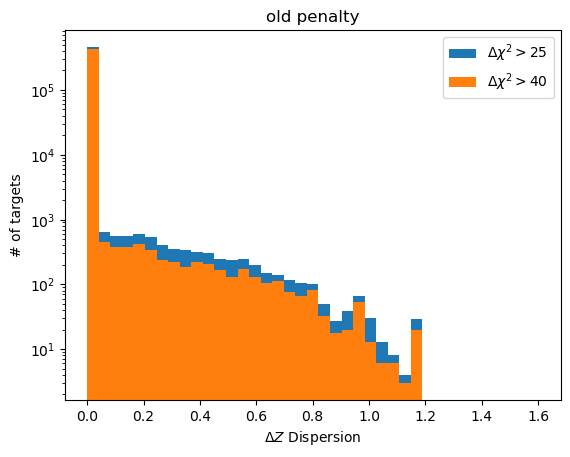

In [162]:
plt.hist([bla for ap in anetdispz[1] for bla in ap ],bins=np.linspace(0,1.6,40),label='$\Delta\chi^2>25$')
plt.hist([bla for ap in anetdispz[0] for bla in ap ],bins=np.linspace(0,1.6,40),label='$\Delta\chi^2>40$')
plt.title('old penalty')
plt.yscale('log')
plt.xlabel('$\Delta Z$ Dispersion')
plt.ylabel('# of targets')
plt.legend()

In [180]:
dum=[bla for ap in anetdispz[1] for bla in ap ]
dum=np.array(dum)
frac=len(dum[dum>1e3/3e5])/len(dum)*100
print(frac)

dum=[bla for ap in anetdispz[0] for bla in ap ]
dum=np.array(dum)
frac=len(dum[dum>1e3/3e5])/len(dum)*100
print(frac)

dum=[bla for ap in anetdispznew[1] for bla in ap ]
dum=np.array(dum)
frac=len(dum[dum>1e3/3e5])/len(dum)*100
print(frac)

dum=[bla for ap in anetdispznew[0] for bla in ap ]
dum=np.array(dum)
frac=len(dum[dum>1e3/3e5])/len(dum)*100
print(frac)

1.588261050653054
1.123621041531252
1.5692514711065069
1.103848583882947


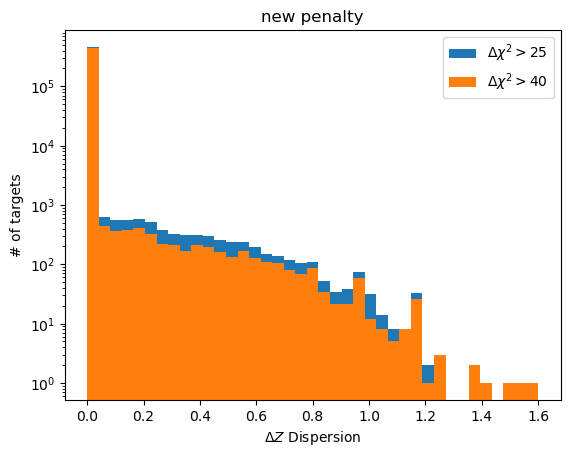

In [163]:
plt.hist([bla for ap in anetdispznew[1] for bla in ap ],bins=np.linspace(0,1.6,40),label='$\Delta\chi^2>25$')
plt.hist([bla for ap in anetdispznew[0] for bla in ap ],bins=np.linspace(0,1.6,40),label='$\Delta\chi^2>40$')
plt.title('new penalty')
plt.yscale('log')
plt.xlabel('$\Delta Z$ Dispersion')
plt.ylabel('# of targets')
plt.legend()

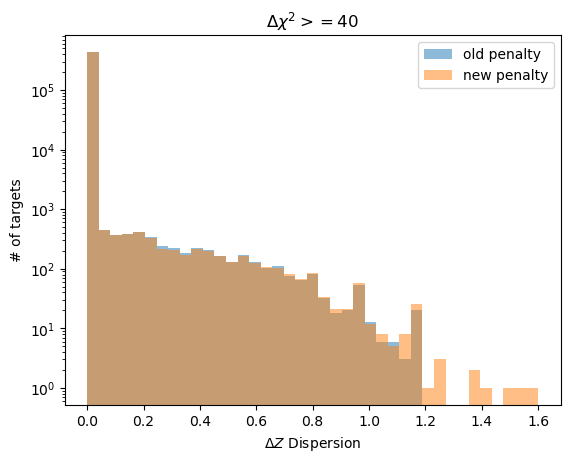

In [164]:
plt.hist([bla for ap in anetdispz[0] for bla in ap ],bins=np.linspace(0,1.6,40),label='old penalty',alpha=0.5)
plt.hist([bla for ap in anetdispznew[0] for bla in ap ],bins=np.linspace(0,1.6,40),label='new penalty',alpha=0.5)
plt.title('$\Delta\chi^2>=40$')
plt.yscale('log')
plt.xlabel('$\Delta Z$ Dispersion')
plt.ylabel('# of targets')
plt.legend()

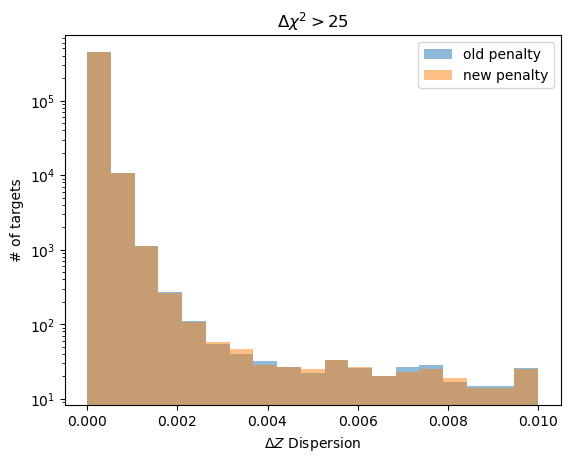

In [165]:
plt.hist([bla for ap in anetdispz[1] for bla in ap ],bins=np.linspace(0,0.01,20),label='old penalty',alpha=0.5)
plt.hist([bla for ap in anetdispznew[1] for bla in ap ],bins=np.linspace(0,0.01,20),label='new penalty',alpha=0.5)
plt.title('$\Delta\chi^2>25$')
plt.yscale('log')
plt.xlabel('$\Delta Z$ Dispersion')
plt.ylabel('# of targets')
plt.legend()

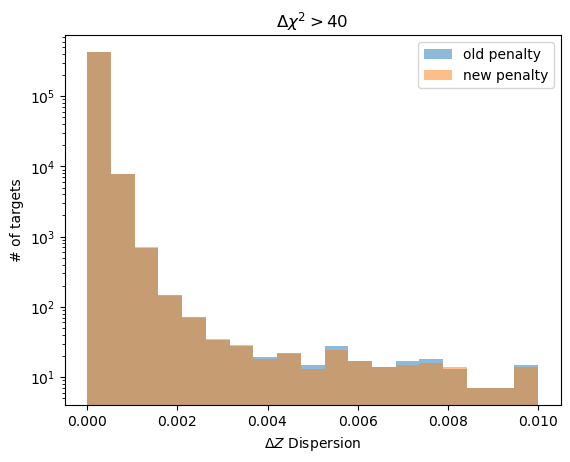

In [166]:
plt.hist([bla for ap in anetdispz[0] for bla in ap ],bins=np.linspace(0,0.01,20),label='old penalty',alpha=0.5)
plt.hist([bla for ap in anetdispznew[0] for bla in ap ],bins=np.linspace(0,0.01,20),label='new penalty',alpha=0.5)
plt.title('$\Delta\chi^2>40$')
plt.yscale('log')
plt.xlabel('$\Delta Z$ Dispersion')
plt.ylabel('# of targets')
plt.legend()

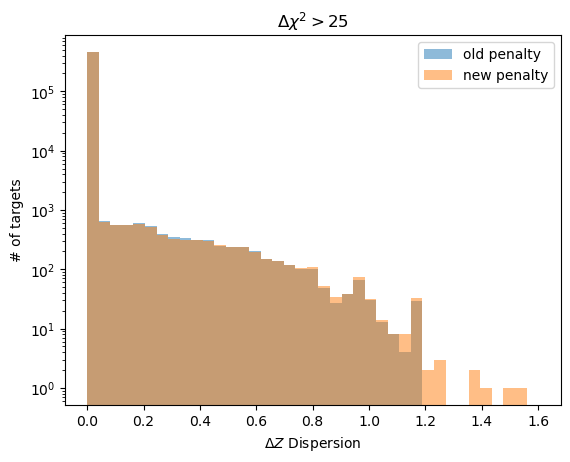

In [167]:
plt.hist([bla for ap in anetdispz[1] for bla in ap ],bins=np.linspace(0,1.6,40),label='old penalty',alpha=0.5)
plt.hist([bla for ap in anetdispznew[1] for bla in ap ],bins=np.linspace(0,1.6,40),label='new penalty',alpha=0.5)
plt.title('$\Delta\chi^2>25$')
plt.yscale('log')
plt.xlabel('$\Delta Z$ Dispersion')
plt.ylabel('# of targets')
plt.legend()

(array([5.98289e+05, 1.98846e+05, 9.86180e+04, 8.32430e+04, 4.71050e+04,
        2.49580e+04, 9.46300e+03, 3.41700e+03, 1.55200e+03, 6.55000e+02,
        1.94000e+02, 8.00000e+01, 1.90000e+01, 1.90000e+01, 1.60000e+01]),
 array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
        14., 15., 16.]),
 <BarContainer object of 15 artists>)

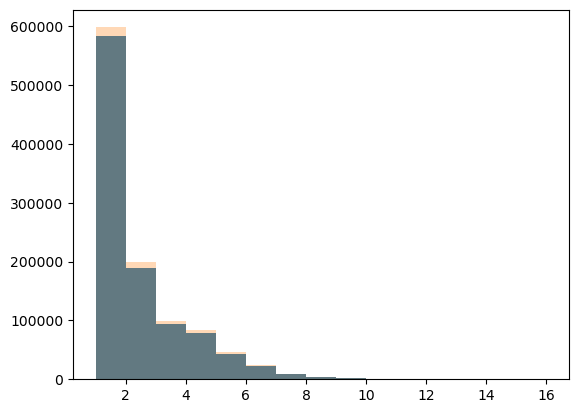

In [19]:
plt.hist(count40,bins=15)
plt.hist(count25,bins=15, alpha=0.3)

In [63]:
mask=[count40==1]
repeatedtargetsmasked=ma.array(unique40, mask = mask)
catrepeated=repeatedtargetsmasked[inverse40]
catrepeated=catrepeated.compressed()

In [91]:
inds=catrepeated.argsort()
catrepeated_sort=catrepeated[inds]
catrepeated1_sort=catrepeated1[inds]

In [92]:
catrepeated_sort

array([      6448025174016,       6448025174016,       6536638234624, ...,
       2305843042155806193, 2305843042155806193, 2305843042155806193])

In [93]:
catrepeated1_sort

0.022176204806285005
0.022190276431036042
0.07641130180355753
0.07640182778371221
0.07641036826962579
-6.441420960364188e-05
-6.296559827022372e-05
0.09718206620657655
0.09718576699642646
-5.6536079147856486e-06
7.164155159831654e-05


In [95]:
cat40[cat40['TARGETID']==6448025174016]

TARGETID,Z,ZWARN,SPECTYPE,DELTACHI2,TARGET_RA,TARGET_DEC,OBJTYPE,OII_FLUX,OII_FLUX_IVAR,OII_SIGMA,OII_SIGMA_IVAR,OII_CONT,OII_CONT_IVAR,OII_SHARE,OII_SHARE_IVAR,OII_EW,OII_EW_IVAR,OII_CHI2,OII_NDOF,HDELTA_FLUX,HDELTA_FLUX_IVAR,HDELTA_SIGMA,HDELTA_SIGMA_IVAR,HDELTA_CONT,HDELTA_CONT_IVAR,HDELTA_SHARE,HDELTA_SHARE_IVAR,HDELTA_EW,HDELTA_EW_IVAR,HDELTA_CHI2,HDELTA_NDOF,HGAMMA_FLUX,HGAMMA_FLUX_IVAR,HGAMMA_SIGMA,HGAMMA_SIGMA_IVAR,HGAMMA_CONT,HGAMMA_CONT_IVAR,HGAMMA_SHARE,HGAMMA_SHARE_IVAR,HGAMMA_EW,HGAMMA_EW_IVAR,HGAMMA_CHI2,HGAMMA_NDOF,HBETA_FLUX,HBETA_FLUX_IVAR,HBETA_SIGMA,HBETA_SIGMA_IVAR,HBETA_CONT,HBETA_CONT_IVAR,HBETA_SHARE,HBETA_SHARE_IVAR,HBETA_EW,HBETA_EW_IVAR,HBETA_CHI2,HBETA_NDOF,OIII_FLUX,OIII_FLUX_IVAR,OIII_SIGMA,OIII_SIGMA_IVAR,OIII_CONT,OIII_CONT_IVAR,OIII_SHARE,OIII_SHARE_IVAR,OIII_EW,OIII_EW_IVAR,OIII_CHI2,OIII_NDOF,HALPHA_FLUX,HALPHA_FLUX_IVAR,HALPHA_SIGMA,HALPHA_SIGMA_IVAR,HALPHA_CONT,HALPHA_CONT_IVAR,HALPHA_SHARE,HALPHA_SHARE_IVAR,HALPHA_EW,HALPHA_EW_IVAR,HALPHA_CHI2,HALPHA_NDOF,RRFN,TILEID,FN,RRN,COADDFN,FIBERSTATUS,BGS_TARGET,COADD_EXPTIME,DESI_TARGET,SV1_DESI_TARGET,SV1_BGS_TARGET,penoiii_right,penoiii_left,penoii,zrr,zchi2rr,old_pen,old_chi2_no_pen,pen_tot,pen_difference,new_chi2_with_penalty,oldest_chi2_without_penalty,newbestmodel,new_model_order,new_deltachi2,z_new,SV3_DESI_TARGET,SV3_BGS_TARGET,SV2_DESI_TARGET,SV2_BGS_TARGET
int64,float64,int64,bytes6,float64,float64,float64,bytes3,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32,bytes101,int64,bytes100,bytes101,bytes99,int32,int64,float32,int64,int64,int64,float64[9],float64[9],float64[9],float64[9],float64[9],float64[9],float64[9],float64[9],float64[9],float64[9],float64[9],int64,int64[9],float64,float64,int64,int64,int64,int64
6448025174016,0.022190276431036042,0,GALAXY,45.51037697750144,179.15657,28.4234799,TGT,14.238442,0.061398685,1.3691341,1.514185,-0.032247327,0.18490349,0.42660245,29.645357,-431.95352,6.671293e-05,18.661907,102,-1.241093,0.10995295,3.1246445,0.013096932,0.41788518,1.797748,--,--,-2.9054646,0.020062467,0.2452293,100,-1.3950509,0.30026272,1.9720126,0.112688795,0.44903278,2.410394,--,--,-3.0393467,0.063258804,0.07511215,100,-2.4886177,0.1444605,10.0,0.006700382,0.31395987,5.641814,--,--,-7.754473,0.014878559,0.005374539,100,2.112458,0.6696355,1.2954488,1.3524896,0.3124408,5.901291,0.744,inf,6.614372,0.06830263,0.004522968,162,3.5933275,5.076778,0.6403762,132.77315,0.21210827,19.792166,--,--,16.573242,0.23865297,0.00018539437,100,/global/cfs/cdirs/desi/spectro/redux/iron/tiles/pernight/80856/20210316/redrock-3-80856-20210316.fits,80856,/global/cfs/cdirs/desi/spectro/redux/iron/tiles/pernight/80856/20210316/emline-3-80856-20210316.fits,/global/cfs/cdirs/desi/spectro/redux/iron/tiles/pernight/80856/20210316/rrdetails-3-80856-20210316.h5,/global/cfs/cdirs/desi/spectro/redux/iron/tiles/pernight/80856/20210316/coadd-3-80856-20210316.fits,0,0,1544.8451,0,4611686018427387904,0,0.3552037215362077 .. 0.0,0.04298738988941631 .. 0.0,0.05051204055630196 .. 0.0,0.022190276431036042 .. 1.4004310199001406,7938.584133071126 .. 8083.814522578497,0.0 .. 0.0,7939.757736943964 .. 0.0,0.448703151981926 .. 0.0,0.448703151981926 .. 0.0,7939.0328362231085 .. 8083.814522578497,7938.584133071126 .. 8083.814522578497,0,0 .. 8,52.350096152426886,0.022190276431036042,--,--,--,--
6448025174016,0.022176204806285005,0,GALAXY,81.946598588489,179.15657,28.4234799,TGT,--,--,--,--,0.29991773,0.13025555,--,--,--,--,--,-99,-5.6543174,0.106373705,3.529804,0.20479853,0

In [59]:
catrepeated1=ma.array(cat40['Z'], mask = mask2)


In [67]:
catrepeated1=catrepeated1.compressed()

In [68]:
catrepeated1

0.5230546528324151
0.6062884011082841
0.1393712427973666
0.1388750102239285
0.48607980551918706
0.31679371594995454
0.3252724253195879
0.2274608622591915
0.29551371462556947
0.31959314366884156
0.2712935400802967


In [69]:
asa=t.hstack(catrepeated,catrepeated1)

TypeError: `join_type` arg must be a string

In [79]:
catnew=t.Table()
catrepeated.add_columns(catrepeated1)

AttributeError: 'BaseColumn' object has no attribute 'add_columns'

In [196]:
repeated=unique25[count25>1]
repeated=repeated[:2]
# repeatedcat=[[cat] if cata+
repeatedcat=[[cat[cat['TARGETID']==x]] for x in repeated]

In [199]:
repeatedcat=np.array(repeatedcat)

In [201]:
repeatedcat

array([[[(6448025174016, 0.02219028, 0, b'GALAXY', 45.51037698, 179.15657 , 28.4234799, b'TGT', 14.238442 , 0.06139868, 1.3691341 ,  1.514185  , -0.03224733, 0.18490349, 0.42660245, 29.645357 , -431.95352 , 6.6712928e-05, 18.661907 , 102, -1.2410930e+00, 1.09952949e-01,  3.1246445, 1.3096932e-02, 0.41788518, 1.797748 , nan, nan, -2.9054646e+00, 2.0062467e-02, 0.2452293 , 100, -1.3950509, 0.30026272,  1.9720126, 1.12688795e-01, 0.44903278, 2.410394 , nan, nan,  -3.0393467, 0.0632588 , 0.07511215, 100, -2.4886177, 1.4446050e-01, 10.        , 6.70038210e-03, 0.31395987, 5.641814 , nan, nan, -7.754473 , 1.4878559e-02, 0.00537454, 100, 2.112458 , 0.6696355 , 1.2954488 ,  1.3524896 , 0.3124408 , 5.901291 , 0.744, inf,  6.614372 , 0.06830263, 0.00452297, 162, 3.5933275, 5.076778 , 0.6403762 , 132.77315, 0.21210827, 19.792166, nan, nan, 16.573242, 0.23865297, 0.00018539, 100, b'/global/cfs/cdirs/desi/spectro/redux/iron/tiles/pernight/80856/20210316/redrock-3-80856-20210316.fits', 80856, b'/glo

In [182]:
multiple25 ,= np.where(count25>1)
var25or=[]
for num,objid in enumerate(unique25[multiple25]):
    observations ,= np.where(cat["TARGETID"]==objid)
    print(num)
    var25or.append(np.std(cat['Z'][observations], ddof=1))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

KeyboardInterrupt: 

In [156]:
cat['Z']['']

['TARGETID',
 'Z',
 'ZWARN',
 'SPECTYPE',
 'DELTACHI2',
 'TARGET_RA',
 'TARGET_DEC',
 'OBJTYPE',
 'OII_FLUX',
 'OII_FLUX_IVAR',
 'OII_SIGMA',
 'OII_SIGMA_IVAR',
 'OII_CONT',
 'OII_CONT_IVAR',
 'OII_SHARE',
 'OII_SHARE_IVAR',
 'OII_EW',
 'OII_EW_IVAR',
 'OII_CHI2',
 'OII_NDOF',
 'HDELTA_FLUX',
 'HDELTA_FLUX_IVAR',
 'HDELTA_SIGMA',
 'HDELTA_SIGMA_IVAR',
 'HDELTA_CONT',
 'HDELTA_CONT_IVAR',
 'HDELTA_SHARE',
 'HDELTA_SHARE_IVAR',
 'HDELTA_EW',
 'HDELTA_EW_IVAR',
 'HDELTA_CHI2',
 'HDELTA_NDOF',
 'HGAMMA_FLUX',
 'HGAMMA_FLUX_IVAR',
 'HGAMMA_SIGMA',
 'HGAMMA_SIGMA_IVAR',
 'HGAMMA_CONT',
 'HGAMMA_CONT_IVAR',
 'HGAMMA_SHARE',
 'HGAMMA_SHARE_IVAR',
 'HGAMMA_EW',
 'HGAMMA_EW_IVAR',
 'HGAMMA_CHI2',
 'HGAMMA_NDOF',
 'HBETA_FLUX',
 'HBETA_FLUX_IVAR',
 'HBETA_SIGMA',
 'HBETA_SIGMA_IVAR',
 'HBETA_CONT',
 'HBETA_CONT_IVAR',
 'HBETA_SHARE',
 'HBETA_SHARE_IVAR',
 'HBETA_EW',
 'HBETA_EW_IVAR',
 'HBETA_CHI2',
 'HBETA_NDOF',
 'OIII_FLUX',
 'OIII_FLUX_IVAR',
 'OIII_SIGMA',
 'OIII_SIGMA_IVAR',
 'OIII_CONT',
 